In [4]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

from scipy.stats import ttest_ind

from statsmodels.graphics.mosaicplot import mosaic

import re

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


In [5]:
transaction_data = pd.read_excel('QVI_transaction_data.xlsx')
purchase_behaviour_data = pd.read_csv('QVI_purchase_behaviour.csv')

# Explornatory Data Analysis

- The first step in any analysis is to first understand the data. Let's take a look
at each of the datasets provided.

In [6]:
from ydata_profiling import ProfileReport
profile=ProfileReport(transaction_data)

profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Examining transaction data

- From the above brief profile, We can see that the date column is in an integer format while numeric are in the correct form. . Let's change this to a
date format. 

In [7]:
# If necessary, explicitly convert to datetime
transaction_data['DATE'] = pd.to_datetime(transaction_data['DATE'])

# Display a sample to confirm
print(transaction_data['DATE'].head())

0   1970-01-01 00:00:00.000043390
1   1970-01-01 00:00:00.000043599
2   1970-01-01 00:00:00.000043605
3   1970-01-01 00:00:00.000043329
4   1970-01-01 00:00:00.000043330
Name: DATE, dtype: datetime64[ns]


- The DATE column seems to have been incorrectly converted, as the values are being interpreted as nanoseconds since 1970-01-01, rather than proper dates. This likely happened because the original values were misinterpreted during the conversion process.

- To fix this, we need to ensure the DATE column is interpreted as Excel serial dates and converted accordingly. Here's the correct approach:

In [8]:
# Convert to numeric if necessary
transaction_data['DATE'] = pd.to_numeric(transaction_data['DATE'], errors='coerce')

# Apply proper conversion from Excel serial date format
transaction_data['DATE'] = pd.to_datetime('1899-12-30') + pd.to_timedelta(transaction_data['DATE'], unit='D')

# Verify the conversion
print(transaction_data['DATE'].head())

0   2018-10-17
1   2019-05-14
2   2019-05-20
3   2018-08-17
4   2018-08-18
Name: DATE, dtype: datetime64[ns]


- We should check that we are looking at the right products by examining PROD_NAME.

- From the above profile, we observed the High Frequencies: Words like "175g," "Chips," "150g," and brand names appear frequently, reflecting raw popularity of terms. Now we want the look at the unique product names or has been filtered further to highlights unique terms across products

In [9]:
# Step 1: Extract unique product names
unique_product_names = transaction_data['PROD_NAME'].unique()

# Step 2: Split product names into individual words
product_words = pd.DataFrame({'words': ' '.join(unique_product_names).split()})

# Step 3: Summarize word frequency (if needed)
word_counts = product_words['words'].value_counts().reset_index()
word_counts.columns = ['Word', 'Frequency']

# Display the resulting word frequency DataFrame
print(word_counts.head(20))


        Word  Frequency
0       175g         26
1      Chips         21
2       150g         19
3          &         17
4     Smiths         16
5    Crinkle         14
6        Cut         14
7     Kettle         13
8       Salt         12
9     Cheese         12
10  Original         10
11     Salsa          9
12      Chip          9
13   Doritos          9
14  Pringles          8
15      134g          8
16      170g          8
17      Corn          8
18      165g          8
19       RRD          8


- The most popular packaging sizes are 175g, 150g, and 170g, with leading brands like Smiths, Kettle, and Doritos. Key flavors such as Salt, Cheese, and Salsa dominate, indicating strong customer preferences.

In [10]:
# Step 1: Extract all unique product names
unique_product_names = transaction_data['PROD_NAME'].unique()

# Step 2: Tokenize product names into words
all_words = ' '.join(unique_product_names).split()

# Step 3: Remove words with digits or special characters
cleaned_words = [word for word in all_words if not re.search(r'[0-9&@#*!]', word)]

# Step 4: Count word frequencies
word_counts = Counter(cleaned_words)

# Step 5: Convert to DataFrame for sorting and visualization
word_freq_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Display the most common words
print(word_freq_df.head(20))

         Word  Frequency
9       Chips         21
6      Smiths         16
7     Crinkle         14
8         Cut         14
12     Kettle         13
22       Salt         12
5      Cheese         12
40   Original         10
18      Salsa          9
1        Chip          9
28    Doritos          9
29       Corn          8
60   Pringles          8
120       RRD          8
37         WW          7
10    Chicken          7
54        Sea          6
32       Sour          6
102    Crisps          5
23    Vinegar          5


- There are salsa products in the dataset but we are only interested in the chips category, so let's remove these.

In [11]:
# Add a new column to indicate whether a product contains "salsa"
transaction_data['SALSA'] = transaction_data['PROD_NAME'].str.contains('salsa', case=False, na=False)

# Remove rows where SALSA is True
transaction_data = transaction_data[~transaction_data['SALSA']].drop(columns=['SALSA'])

# Display the first few rows to confirm
print(transaction_data.head())

        DATE  STORE_NBR  LYLTY_CARD_NBR  TXN_ID  PROD_NBR  \
0 2018-10-17          1            1000       1         5   
1 2019-05-14          1            1307     348        66   
2 2019-05-20          1            1343     383        61   
3 2018-08-17          2            2373     974        69   
4 2018-08-18          2            2426    1038       108   

                                  PROD_NAME  PROD_QTY  TOT_SALES  
0    Natural Chip        Compny SeaSalt175g         2        6.0  
1                  CCs Nacho Cheese    175g         3        6.3  
2    Smiths Crinkle Cut  Chips Chicken 170g         2        2.9  
3    Smiths Chip Thinly  S/Cream&Onion 175g         5       15.0  
4  Kettle Tortilla ChpsHny&Jlpno Chili 150g         3       13.8  


- Check summary statistics such as mean, min and max values for each feature to see if there are any obvious outliers in the data and if there are any nulls in any of the columns

- There are no nulls in the columns but product quantity appears to have an outlier which we should investigate further. Let's investigate further the case where 200 packets of chips are bought in one transaction.

In [12]:
# Filter the dataset for transactions with 200 packets of chips
outlier_transactions = transaction_data[transaction_data['PROD_QTY'] == 200]

# Count the number of outlier transactions
outlier_count = outlier_transactions.shape[0]

# Display the outlier transactions and their count
outlier_transactions, outlier_count


(            DATE  STORE_NBR  LYLTY_CARD_NBR  TXN_ID  PROD_NBR  \
 69762 2018-08-19        226          226000  226201         4   
 69763 2019-05-20        226          226000  226210         4   
 
                               PROD_NAME  PROD_QTY  TOT_SALES  
 69762  Dorito Corn Chp     Supreme 380g       200      650.0  
 69763  Dorito Corn Chp     Supreme 380g       200      650.0  ,
 2)

- There are two transactions where 200 packets of chips are bought in one store and both of these transactions were by the same customer. 

- Let's see if the customer has had other transactions

In [13]:
# Get unique customer IDs from outlier transactions
customer_ids = outlier_transactions['LYLTY_CARD_NBR'].unique()

# Filter the dataset for transactions made by any of the outlier customers
customer_transactions = transaction_data[transaction_data['LYLTY_CARD_NBR'].isin(customer_ids)]

# Display all transactions for these customers
print(customer_transactions)

            DATE  STORE_NBR  LYLTY_CARD_NBR  TXN_ID  PROD_NBR  \
69762 2018-08-19        226          226000  226201         4   
69763 2019-05-20        226          226000  226210         4   

                              PROD_NAME  PROD_QTY  TOT_SALES  
69762  Dorito Corn Chp     Supreme 380g       200      650.0  
69763  Dorito Corn Chp     Supreme 380g       200      650.0  


- It looks like this customer has only had the two transactions over the year and is not an ordinary retail customer. The customer might be buying chips for commercial purposes instead. We'll remove this loyalty card number from further analysis.

In [14]:
# Identify the customer loyalty card numbers to exclude
exclude_customers = outlier_transactions['LYLTY_CARD_NBR'].unique()

# Filter out transactions made by these customers
filtered_data = transaction_data[~transaction_data['LYLTY_CARD_NBR'].isin(exclude_customers)]

#Re-examine the data cleaning
from ydata_profiling import ProfileReport
profile=ProfileReport(filtered_data)

profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

- I observe that there's only 364 rows, meaning only 364 dates which indicates a missing date. Let's create a sequence of dates from 1 Jul 2018 to 30 Jun 2019 and use this to create a chart of number of transactions over time to find the missing date.

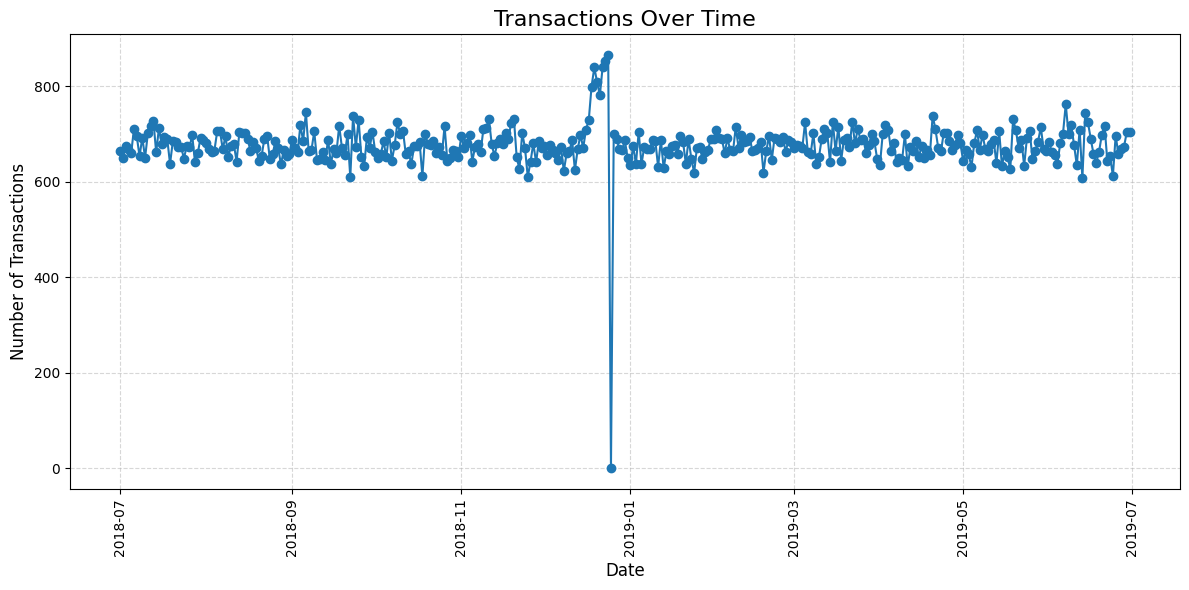

In [15]:
# Step 1: Create a sequence of dates
date_range = pd.date_range(start='2018-07-01', end='2019-06-30', freq='D')
date_df = pd.DataFrame({'DATE': date_range})

# Step 2: Group transactions by day
transactions_by_day = transaction_data.groupby('DATE').size().reset_index(name='Transaction_Count')

# Step 3: Join the sequence of dates with transaction counts
transactions_with_dates = pd.merge(date_df, transactions_by_day, how='left', on='DATE')
transactions_with_dates['Transaction_Count'].fillna(0, inplace=True)

# Step 4: Plot transactions over time
plt.figure(figsize=(12, 6))
plt.plot(transactions_with_dates['DATE'], transactions_with_dates['Transaction_Count'], marker='o', linestyle='-')
plt.title('Transactions Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.xticks(rotation=90)
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

- We can see that there is an increase in purchases in December and a break in late December. Let's zoom in on this.

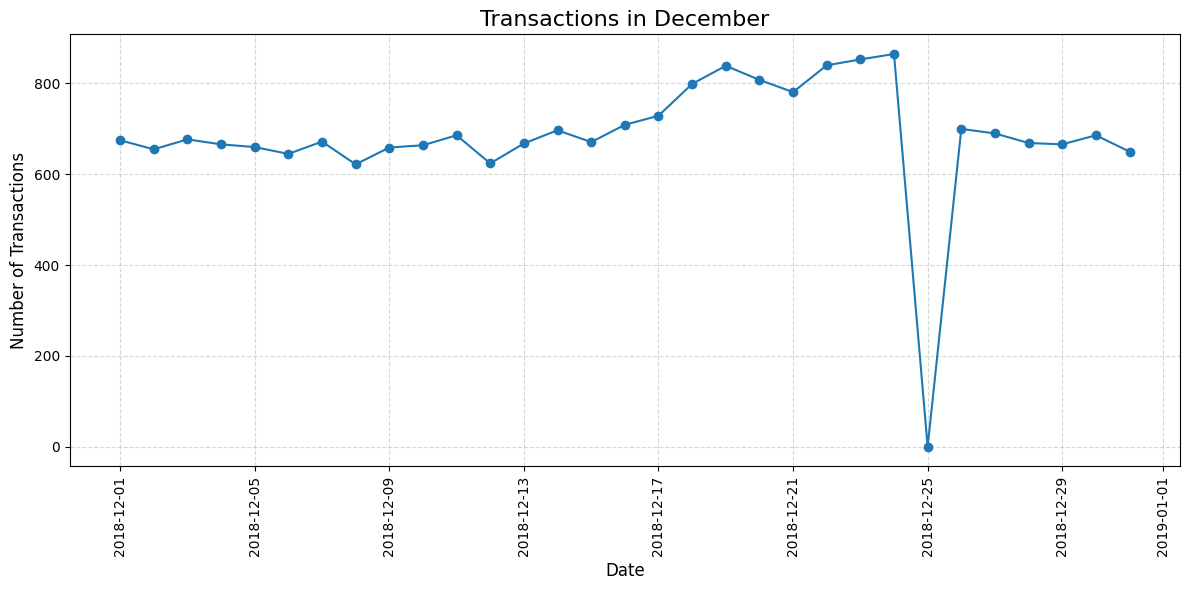

In [16]:
# Step 1: Filter the data to include only December
december_data = transactions_with_dates[transactions_with_dates['DATE'].dt.month == 12]


# Step 2: Plot transactions for December
plt.figure(figsize=(12, 6))
plt.plot(december_data['DATE'], december_data['Transaction_Count'], marker='o', linestyle='-')
plt.title('Transactions in December', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.xticks(rotation=90)
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

- We can see that the increase in sales occurs in the lead-up to Christmas and that there are zero sales on Christmas day itself. This is due to shops being closed on Christmas day.

- Now that we are satisfied that the data no longer has outliers, we can move on to creating other features such as brand of chips or pack size from PROD_NAME. We will start with pack size.

In [17]:
# Step 1: Extract pack size from the product name
transaction_data['PACK_SIZE'] = transaction_data['PROD_NAME'].str.extract(r'(\d+)').astype(float)

# Step 2: Check if the pack sizes look sensible
pack_size_summary = transaction_data.groupby('PACK_SIZE').size().reset_index(name='Count').sort_values(by='PACK_SIZE')

# Display the results
print(pack_size_summary)

    PACK_SIZE  Count
0        70.0   1507
1        90.0   3008
2       110.0  22387
3       125.0   1454
4       134.0  25102
5       135.0   3257
6       150.0  40203
7       160.0   2970
8       165.0  15297
9       170.0  19983
10      175.0  66390
11      180.0   1468
12      190.0   2995
13      200.0   4473
14      210.0   6272
15      220.0   1564
16      250.0   3169
17      270.0   6285
18      330.0  12540
19      380.0   6418


- The largest size is 380g and the smallest size is 70g - seems sensible! Let's plot a histogram of PACK_SIZE since we know that it is a categorical
variable and not a continuous variable even though it is numeric.

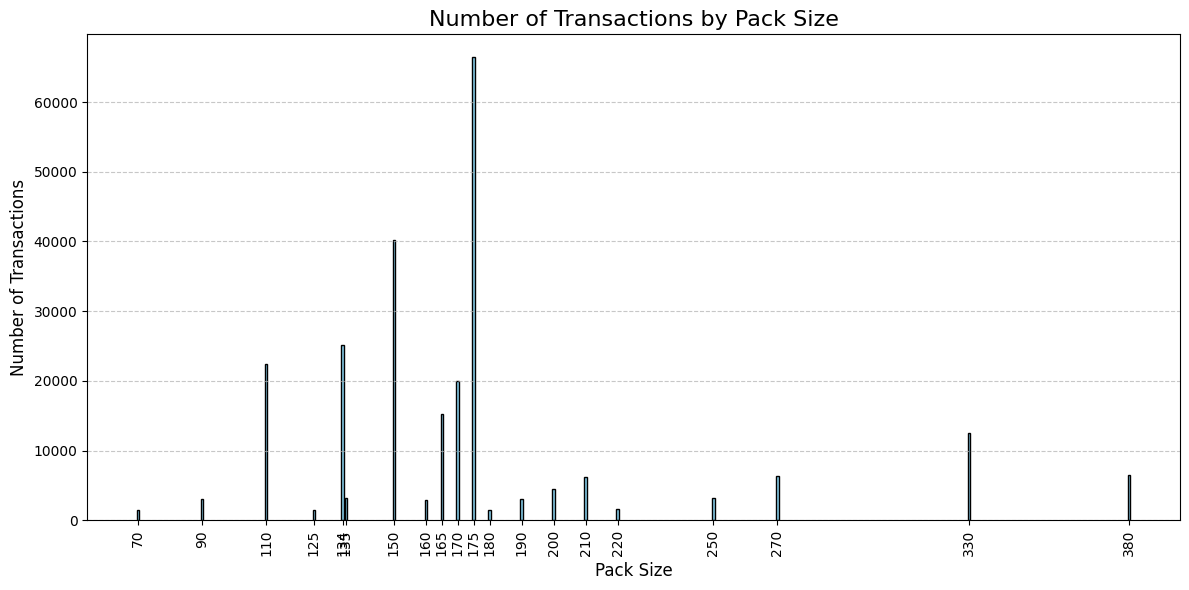

In [18]:
# Step 1: Extract pack size from the product name
transaction_data['PACK_SIZE'] = transaction_data['PROD_NAME'].str.extract(r'(\d+)').astype(float)

# Step 2: Check if the pack sizes look sensible
pack_size_summary = transaction_data.groupby('PACK_SIZE').size().reset_index(name='Count').sort_values(by='PACK_SIZE')

# Step 3: Plot a histogram of PACK_SIZE
plt.figure(figsize=(12, 6))
plt.bar(pack_size_summary['PACK_SIZE'], pack_size_summary['Count'], color='skyblue', edgecolor='black')
plt.title('Number of Transactions by Pack Size', fontsize=16)
plt.xlabel('Pack Size', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.xticks(pack_size_summary['PACK_SIZE'], rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

- Now to create brands, we can use the first word in PROD_NAME to work out the brand name.

In [19]:
# Step 1: Extract the brand name from the product name
# Assuming the brand is the first word in the PROD_NAME column
transaction_data['BRAND'] = transaction_data['PROD_NAME'].str.split().str[0]

# Step 2: Check if the extracted brands look reasonable
brand_summary = transaction_data['BRAND'].value_counts().reset_index()
brand_summary.columns = ['Brand', 'Count']

# Display the brand summary
print(brand_summary)

         Brand  Count
0       Kettle  41288
1       Smiths  27390
2     Pringles  25102
3      Doritos  22041
4        Thins  14075
5          RRD  11894
6    Infuzions  11057
7           WW  10320
8         Cobs   9693
9     Tostitos   9471
10    Twisties   9454
11    Tyrrells   6442
12       Grain   6272
13     Natural   6050
14    Cheezels   4603
15         CCs   4551
16         Red   4427
17      Dorito   3185
18      Infzns   3144
19       Smith   2963
20     Cheetos   2927
21       Snbts   1576
22      Burger   1564
23  Woolworths   1516
24     GrnWves   1468
25    Sunbites   1432
26         NCC   1419
27      French   1418


- Some of the brand names look like they are of the same brands - such as RED and RRD, which are both Red Rock Deli chips. Let's combine these together.

In [20]:
# Step 1: Extract the brand name from the product name
transaction_data['BRAND'] = transaction_data['PROD_NAME'].str.split().str[0]

# Step 2: Standardize similar brand names
brand_mapping = {
    'Smith': 'Smiths',
    'Dorito': 'Doritos',
    'Infzns': 'Infuzions',
    'Snbts': 'Sunbites',
    'GrnWves': 'Grain Waves',
    'Red': 'RRD'
}

# Apply the mapping to clean and standardize brand names
transaction_data['BRAND'] = transaction_data['BRAND'].replace(brand_mapping)

# Step 3: Recalculate the cleaned brand summary
cleaned_brand_summary = transaction_data['BRAND'].value_counts().reset_index()
cleaned_brand_summary.columns = ['Brand', 'Count']

# Display the cleaned brand summary
cleaned_brand_summary

Brand  Count
0        Kettle  41288
1        Smiths  30353
2       Doritos  25226
3      Pringles  25102
4           RRD  16321
5     Infuzions  14201
6         Thins  14075
7            WW  10320
8          Cobs   9693
9      Tostitos   9471
10     Twisties   9454
11     Tyrrells   6442
12        Grain   6272
13      Natural   6050
14     Cheezels   4603
15          CCs   4551
16     Sunbites   3008
17      Cheetos   2927
18       Burger   1564
19   Woolworths   1516
20  Grain Waves   1468
21          NCC   1419
22       French   1418

### Examining customer data

In [21]:
from ydata_profiling import ProfileReport
profile=ProfileReport(purchase_behaviour_data)

profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

- Comments:


#### Merge transaction data to customer data

In [22]:
# Merge transaction data with purchase behaviour data
merged_data = pd.merge(transaction_data, purchase_behaviour_data, 
                       on='LYLTY_CARD_NBR', how='left')

# Display the merged data
print(merged_data.head())

        DATE  STORE_NBR  LYLTY_CARD_NBR  TXN_ID  PROD_NBR  \
0 2018-10-17          1            1000       1         5   
1 2019-05-14          1            1307     348        66   
2 2019-05-20          1            1343     383        61   
3 2018-08-17          2            2373     974        69   
4 2018-08-18          2            2426    1038       108   

                                  PROD_NAME  PROD_QTY  TOT_SALES  PACK_SIZE  \
0    Natural Chip        Compny SeaSalt175g         2        6.0      175.0   
1                  CCs Nacho Cheese    175g         3        6.3      175.0   
2    Smiths Crinkle Cut  Chips Chicken 170g         2        2.9      170.0   
3    Smiths Chip Thinly  S/Cream&Onion 175g         5       15.0      175.0   
4  Kettle Tortilla ChpsHny&Jlpno Chili 150g         3       13.8      150.0   

     BRAND               LIFESTAGE PREMIUM_CUSTOMER  
0  Natural   YOUNG SINGLES/COUPLES          Premium  
1      CCs  MIDAGE SINGLES/COUPLES           Budge

- As the number of rows in `data` is the same as that of `transactionData`, we can be sure that no duplicates were created. This is because we created `data` by setting `all.x = TRUE` (in other words, a left join) which means take all the rows in `transactionData` and find rows with matching values in shared columns and then joining the details in these rows to the `x` or the first mentioned table.

- Let's also check if some customers were not matched on by checking for nulls.

In [23]:
# Check for missing customer details in the merged data
missing_customers = merged_data[merged_data[['LIFESTAGE', 'PREMIUM_CUSTOMER']].isnull().any(axis=1)]

# Count and display the number of unmatched customers
missing_count = missing_customers.shape[0]

# Display unmatched customer data
print(f"Number of unmatched customers: {missing_count}")

Number of unmatched customers: 0


## Data analysis on customer segments

Now that the data is ready for analysis, we can define some metrics of interest to
the client:

- Who spends the most on chips (total sales), describing customers by lifestage and how premium their general purchasing behaviour is
- How many customers are in each segment
- How many chips are bought per customer by segment
- What's the average chip price by customer segment

We could also ask our data team for more information. Examples are:

- The customer's total spend over the period and total spend for each transaction
to understand what proportion of their grocery spend is on chips
- Proportion of customers in each customer segment overall to compare against the
mix of customers who purchase chips

Let's start with calculating total sales by LIFESTAGE and PREMIUM_CUSTOMER and
plotting the split by these segments to describe which customer segment contribute
most to chip sales.

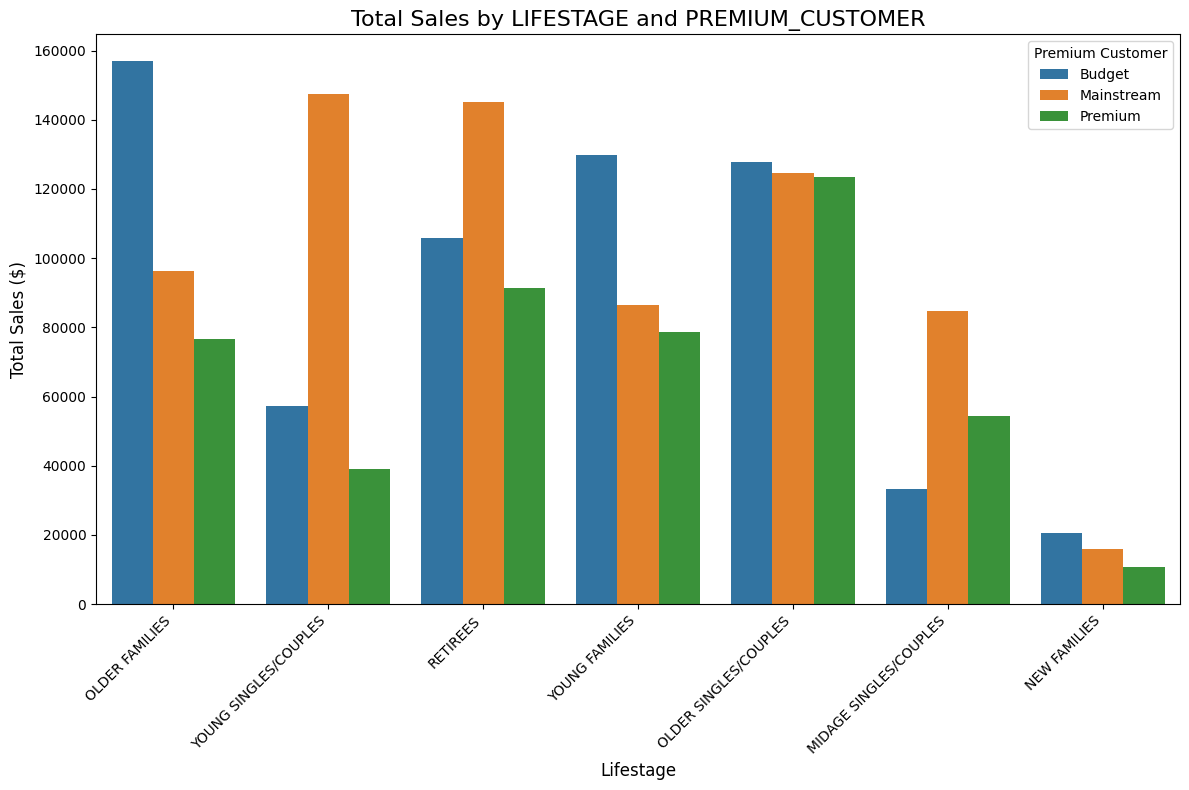

In [24]:
# Step 1: Calculate total sales by LIFESTAGE and PREMIUM_CUSTOMER
sales_summary = merged_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['TOT_SALES'].sum().reset_index()

# Step 2: Sort data for better visualization
sales_summary = sales_summary.sort_values(by='TOT_SALES', ascending=False)

# Step 3: Plot the data
plt.figure(figsize=(12, 8))
sns.barplot(
    data=sales_summary, 
    x='LIFESTAGE', 
    y='TOT_SALES', 
    hue='PREMIUM_CUSTOMER', 
    dodge=True
)
plt.title('Total Sales by LIFESTAGE and PREMIUM_CUSTOMER', fontsize=16)
plt.xlabel('Lifestage', fontsize=12)
plt.ylabel('Total Sales ($)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Premium Customer')
plt.tight_layout()
plt.show()

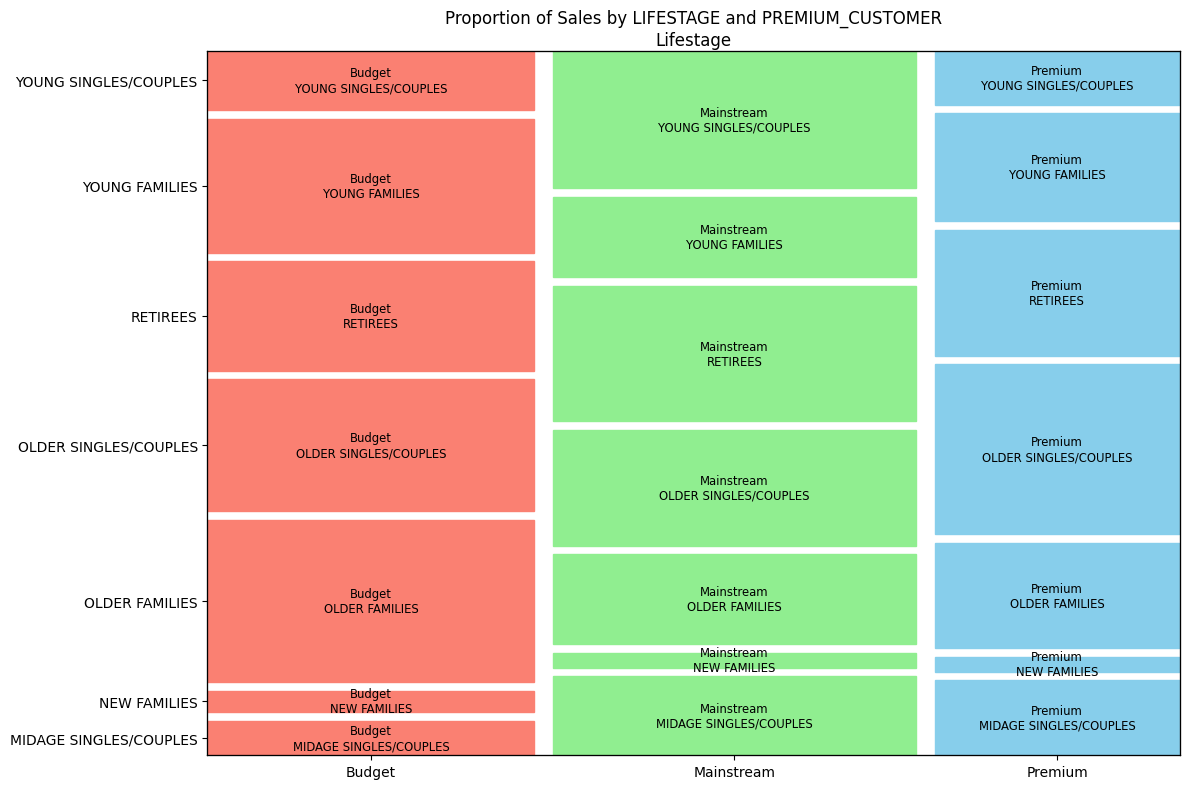

In [25]:
# Step 1: Aggregate total sales by LIFESTAGE and PREMIUM_CUSTOMER
sales = merged_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['TOT_SALES'].sum().reset_index()
sales.columns = ['LIFESTAGE', 'PREMIUM_CUSTOMER', 'SALES']

# Step 2: Calculate total sales and add percentage column
total_sales = sales['SALES'].sum()
sales['PERCENTAGE'] = (sales['SALES'] / total_sales) * 100

# Step 3: Convert data to a format suitable for the mosaic plot
mosaic_data = { (row['PREMIUM_CUSTOMER'], row['LIFESTAGE']): row['SALES'] for _, row in sales.iterrows() }

# Step 4: Create the mosaic plot
fig, ax = plt.subplots(figsize=(12, 8))
props = lambda key: {'color': {'Budget': 'salmon', 'Mainstream': 'lightgreen', 'Premium': 'skyblue'}[key[0]]}
mosaic(mosaic_data, title="Proportion of Sales by LIFESTAGE and PREMIUM_CUSTOMER", 
       gap=0.02, properties=props, ax=ax)


# Final plot adjustments
plt.xlabel("Lifestage", fontsize=12)
plt.ylabel("Premium Customer Flag", fontsize=12)
plt.tight_layout()
plt.show()


- Sales are coming mainly from Budget - older families, Mainstream - young, singles/couples, and Mainstream - retirees while Premium is from older singles/couples

- Let's see if the higher sales are due to there being more customers who buy chips.

In [26]:
# Step 1: Count unique customers by LIFESTAGE and PREMIUM_CUSTOMER
customer_counts = merged_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['LYLTY_CARD_NBR'].nunique().reset_index()
customer_counts.columns = ['LIFESTAGE', 'PREMIUM_CUSTOMER', 'Unique_Customers']

# Step 2: Calculate total sales by LIFESTAGE and PREMIUM_CUSTOMER
sales_summary = merged_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['TOT_SALES'].sum().reset_index()
sales_summary.columns = ['LIFESTAGE', 'PREMIUM_CUSTOMER', 'Total_Sales']

# Step 3: Merge customer counts and sales summaries
customer_sales_analysis = pd.merge(customer_counts, sales_summary, on=['LIFESTAGE', 'PREMIUM_CUSTOMER'])

# Step 4: Add a sales-per-customer metric
customer_sales_analysis['Sales_Per_Customer'] = customer_sales_analysis['Total_Sales'] / customer_sales_analysis['Unique_Customers']

# Display the results
print(customer_sales_analysis)

                 LIFESTAGE PREMIUM_CUSTOMER  Unique_Customers  Total_Sales  \
0   MIDAGE SINGLES/COUPLES           Budget              1474     33345.70   
1   MIDAGE SINGLES/COUPLES       Mainstream              3298     84734.25   
2   MIDAGE SINGLES/COUPLES          Premium              2369     54443.85   
3             NEW FAMILIES           Budget              1087     20607.45   
4             NEW FAMILIES       Mainstream               830     15979.70   
5             NEW FAMILIES          Premium               575     10760.80   
6           OLDER FAMILIES           Budget              4611    156863.75   
7           OLDER FAMILIES       Mainstream              2788     96413.55   
8           OLDER FAMILIES          Premium              2232     76542.60   
9    OLDER SINGLES/COUPLES           Budget              4849    127833.60   
10   OLDER SINGLES/COUPLES       Mainstream              4858    124648.50   
11   OLDER SINGLES/COUPLES          Premium              4682   

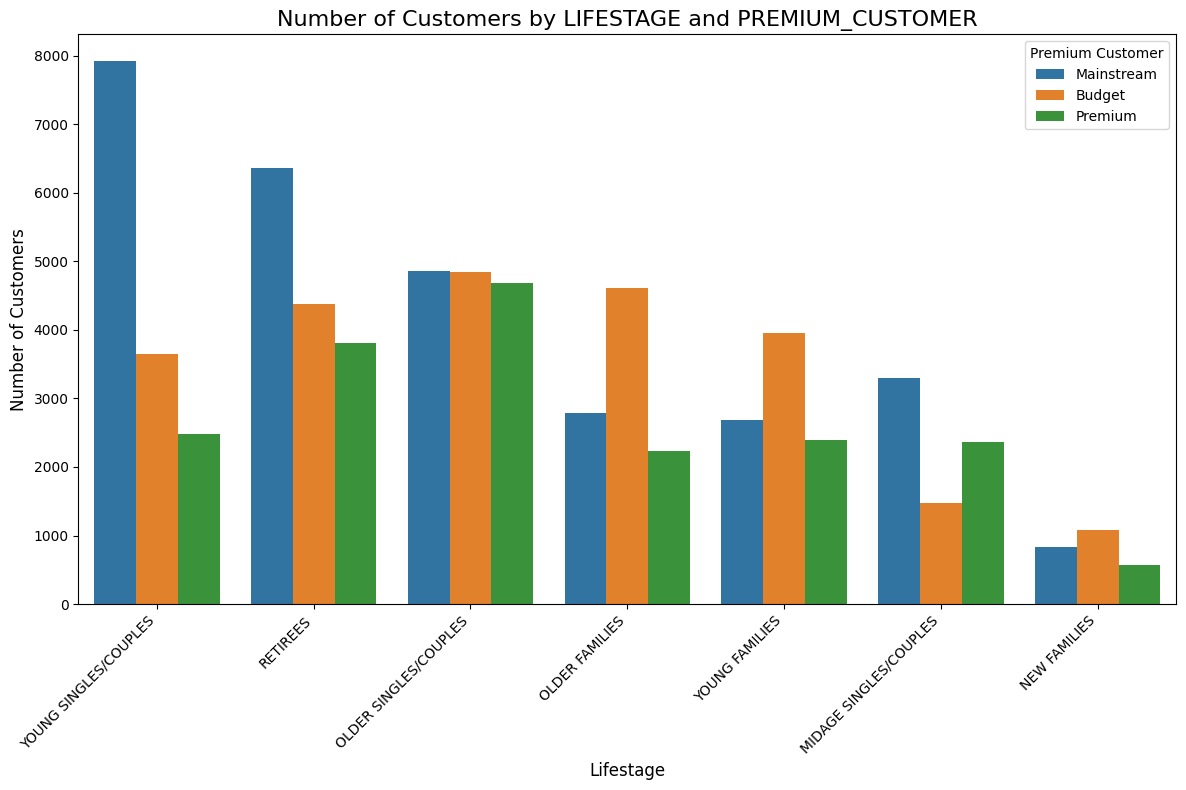

In [27]:
# Step 1: Calculate the number of unique customers by LIFESTAGE and PREMIUM_CUSTOMER
customer_counts = merged_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['LYLTY_CARD_NBR'].nunique().reset_index()
customer_counts.columns = ['LIFESTAGE', 'PREMIUM_CUSTOMER', 'Unique_Customers']

# Step 2: Sort data for better visualization
customer_counts_sorted = customer_counts.sort_values(by='Unique_Customers', ascending=False)

# Step 3: Plot the number of customers by LIFESTAGE and PREMIUM_CUSTOMER
plt.figure(figsize=(12, 8))
sns.barplot(
    data=customer_counts_sorted, 
    x='LIFESTAGE', 
    y='Unique_Customers', 
    hue='PREMIUM_CUSTOMER', 
    dodge=True
)
plt.title('Number of Customers by LIFESTAGE and PREMIUM_CUSTOMER', fontsize=16)
plt.xlabel('Lifestage', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Premium Customer')
plt.tight_layout()
plt.show()


- There are more Mainstream - young singles/couples and Mainstream - retirees who buy chips. This contributes to there being more sales to these customer segments but this is not a major driver for the Budget - Older families segment.

- Higher sales may also be driven by more units of chips being bought per customer. Let's have a look at this next.

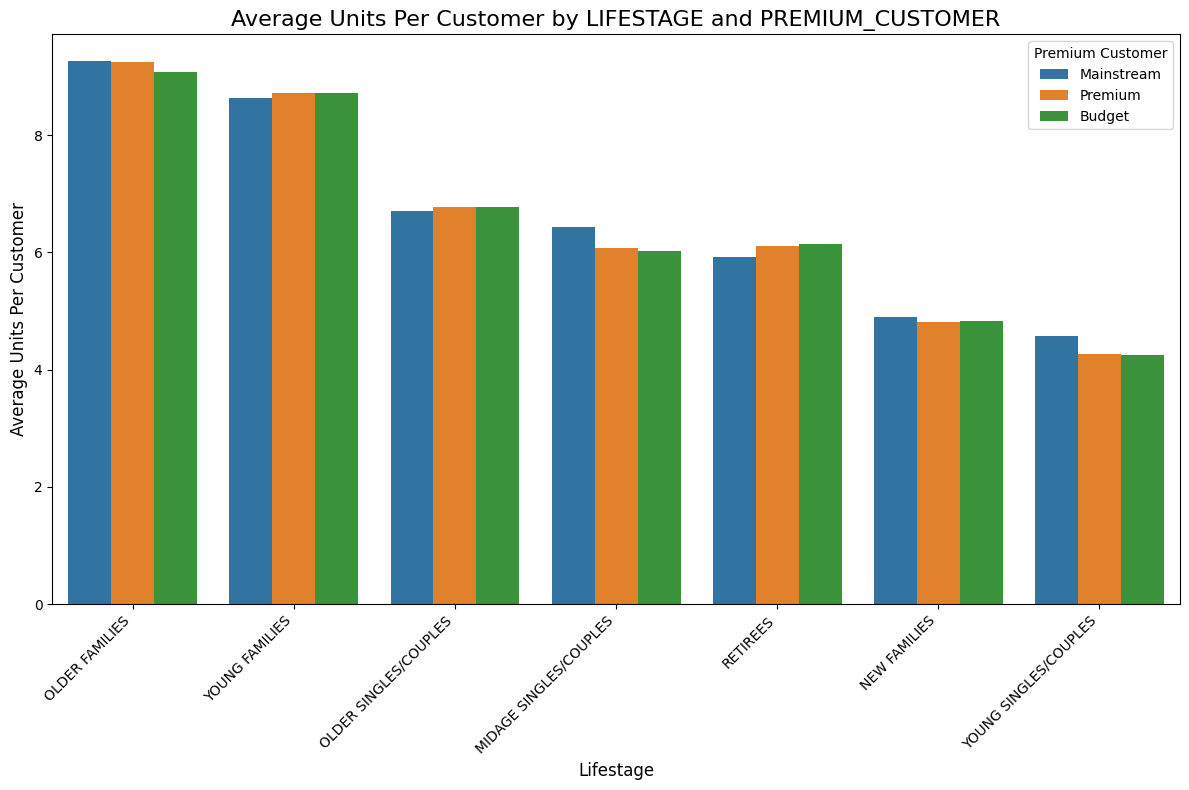

In [28]:
# Step 1: Calculate total units and unique customers by LIFESTAGE and PREMIUM_CUSTOMER
units_summary = merged_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).agg({
    'PROD_QTY': 'sum',  # Total units purchased
    'LYLTY_CARD_NBR': 'nunique'  # Unique customers
}).reset_index()

# Step 2: Calculate the average units per customer
units_summary['Avg_Units_Per_Customer'] = units_summary['PROD_QTY'] / units_summary['LYLTY_CARD_NBR']

# Step 3: Plot the average units per customer
plt.figure(figsize=(12, 8))
sns.barplot(
    data=units_summary.sort_values(by='Avg_Units_Per_Customer', ascending=False), 
    x='LIFESTAGE', 
    y='Avg_Units_Per_Customer', 
    hue='PREMIUM_CUSTOMER', 
    dodge=True
)
plt.title('Average Units Per Customer by LIFESTAGE and PREMIUM_CUSTOMER', fontsize=16)
plt.xlabel('Lifestage', fontsize=12)
plt.ylabel('Average Units Per Customer', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Premium Customer')
plt.tight_layout()
plt.show()

- Older families and young families in general buy more chips per customer

- Let's also investigate the average price per unit chips bought for each customer segment as this is also a driver of total sales.

#### Average price per unit by LIFESTAGE and PREMIUM_CUSTOMER

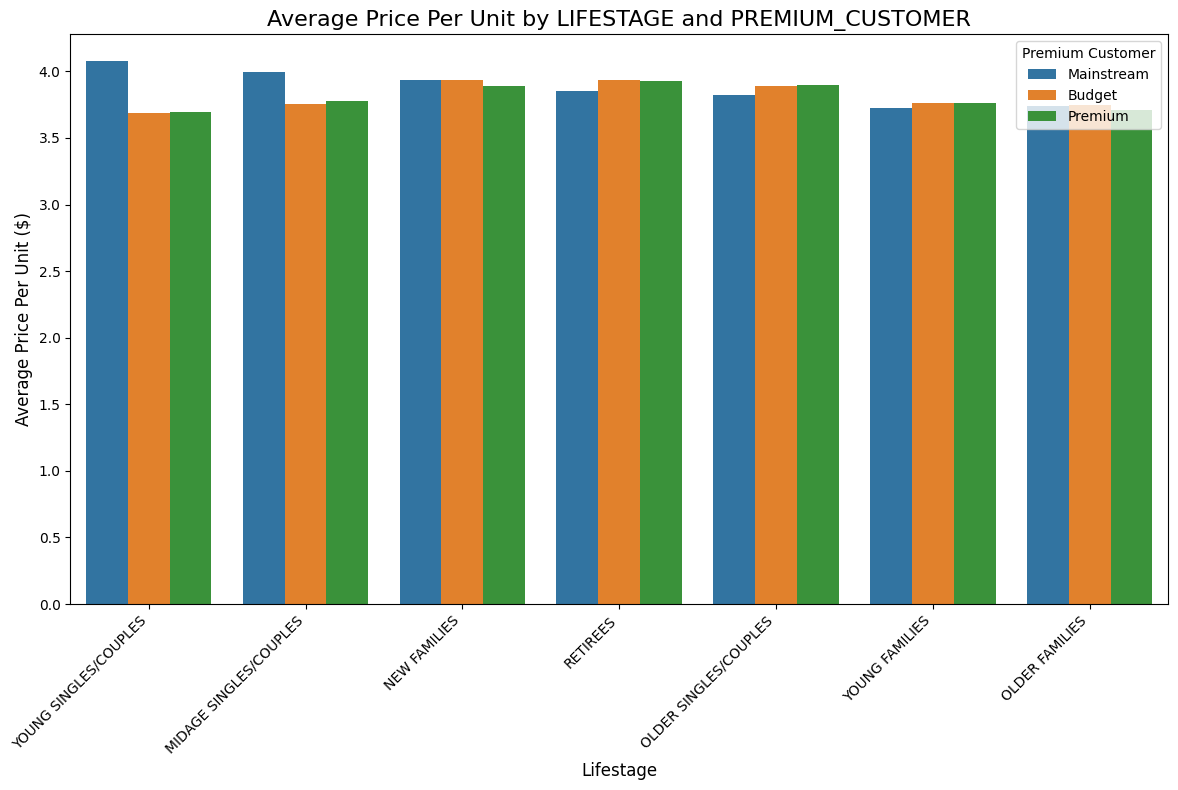

In [29]:
# Step 1: Calculate total sales and total units by LIFESTAGE and PREMIUM_CUSTOMER
price_summary = merged_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).agg({
    'TOT_SALES': 'sum',  # Total sales
    'PROD_QTY': 'sum'    # Total units purchased
}).reset_index()

# Step 2: Calculate the average price per unit
price_summary['Avg_Price_Per_Unit'] = price_summary['TOT_SALES'] / price_summary['PROD_QTY']

# Step 3: Plot the average price per unit
plt.figure(figsize=(12, 8))
sns.barplot(
    data=price_summary.sort_values(by='Avg_Price_Per_Unit', ascending=False), 
    x='LIFESTAGE', 
    y='Avg_Price_Per_Unit', 
    hue='PREMIUM_CUSTOMER', 
    dodge=True
)
plt.title('Average Price Per Unit by LIFESTAGE and PREMIUM_CUSTOMER', fontsize=16)
plt.xlabel('Lifestage', fontsize=12)
plt.ylabel('Average Price Per Unit ($)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Premium Customer')
plt.tight_layout()
plt.show()

- Mainstream midage and young singles and couples are more willing to pay more per packet of chips compared to their budget and premium counterparts. This may be due to premium shoppers being more likely to buy healthy snacks and when they buy chips, this is mainly for entertainment purposes rather than their own consumption.

- This is also supported by there being fewer premium midage and young singles and couples buying chips compared to their mainstream counterparts.

- As the difference in average price per unit isn't large, we can check if this difference is statistically different.

#### Perform an independent t-test between mainstream vs premium and budget midage and young singles and couples

In [30]:
# Step 1: Calculate the price per unit
merged_data['PRICE_PER_UNIT'] = merged_data['TOT_SALES'] / merged_data['PROD_QTY']

# Step 2: Filter data for relevant segments
mainstream_data = merged_data[
    (merged_data['LIFESTAGE'].isin(['YOUNG SINGLES/COUPLES', 'MIDAGE SINGLES/COUPLES'])) &
    (merged_data['PREMIUM_CUSTOMER'] == 'Mainstream')
]['PRICE_PER_UNIT']

non_mainstream_data = merged_data[
    (merged_data['LIFESTAGE'].isin(['YOUNG SINGLES/COUPLES', 'MIDAGE SINGLES/COUPLES'])) &
    (merged_data['PREMIUM_CUSTOMER'] != 'Mainstream')
]['PRICE_PER_UNIT']

# Step 3: Perform the t-test
t_stat, p_value = ttest_ind(mainstream_data.dropna(), non_mainstream_data.dropna(), alternative='greater')

# Display results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")


T-statistic: 37.83196107667815
P-value: 1.11782280577468e-309


- The t-test results in a p-value < 0.05, i.e. the unit price for mainstream, young and mid-age singles and couples are significantly higher than that of budget or premium, young and midage singles and couples.

#### Deep dive into specific customer segments for insights

- We have found quite a few interesting insights that we can dive deeper into.

- We might want to target customer segments that contribute the most to sales to retain them or further increase sales. 

- Let’s look at Mainstream - young singles/couples. For instance, let’s find out if they tend to buy a particular brand of chips.

In [31]:
# Step 1: Filter data for the target segment and the rest of the population
segment1 = merged_data[
    (merged_data['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') & 
    (merged_data['PREMIUM_CUSTOMER'] == 'Mainstream')
]
other = merged_data[
    ~((merged_data['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') & 
      (merged_data['PREMIUM_CUSTOMER'] == 'Mainstream'))
]

# Step 2: Calculate total quantity for the target segment and others
quantity_segment1 = segment1['PROD_QTY'].sum()
quantity_other = other['PROD_QTY'].sum()

# Step 3: Calculate brand proportions for the target segment
quantity_segment1_by_brand = (
    segment1.groupby('BRAND')['PROD_QTY']
    .sum()
    .reset_index()
    .rename(columns={'PROD_QTY': 'targetSegment'})
)
quantity_segment1_by_brand['targetSegment'] /= quantity_segment1

# Step 4: Calculate brand proportions for the rest of the population
quantity_other_by_brand = (
    other.groupby('BRAND')['PROD_QTY']
    .sum()
    .reset_index()
    .rename(columns={'PROD_QTY': 'other'})
)
quantity_other_by_brand['other'] /= quantity_other

# Step 5: Merge the two DataFrames and calculate brand affinity
brand_proportions = pd.merge(
    quantity_segment1_by_brand,
    quantity_other_by_brand,
    on='BRAND',
    how='inner'
)
brand_proportions['affinityToBrand'] = (
    brand_proportions['targetSegment'] / brand_proportions['other']
)

# Step 6: Sort by affinityToBrand in descending order
brand_proportions = brand_proportions.sort_values(by='affinityToBrand', ascending=False)

# Display the results
print(brand_proportions)

          BRAND  targetSegment     other  affinityToBrand
20     Tyrrells       0.031553  0.025669         1.229227
19     Twisties       0.046184  0.037842         1.220443
5       Doritos       0.122761  0.101902         1.204691
10       Kettle       0.197985  0.165401         1.196998
18     Tostitos       0.045411  0.037943         1.196815
13     Pringles       0.119420  0.100542         1.187764
7         Grain       0.029124  0.025098         1.160386
4          Cobs       0.044638  0.039013         1.144177
9     Infuzions       0.064679  0.057012         1.134479
17        Thins       0.060373  0.056934         1.060399
3      Cheezels       0.017971  0.018630         0.964641
15       Smiths       0.096370  0.124469         0.774248
6        French       0.003948  0.005753         0.686201
2       Cheetos       0.008033  0.012055         0.666346
14          RRD       0.043810  0.067432         0.649689
12      Natural       0.015956  0.024958         0.639313
11          NC

We can see that :

+ Mainstream young singles/couples are 23% more likely to purchase Tyrrells chips compared to the rest of the population

+ Mainstreamyoungsingles/couples are 56% less likely to purchase Burger Rings compared to the rest of the population

Let’s also find out if our target segment tends to buy larger packs of chips.

In [32]:
# Step 1: Calculate total quantity for the target segment and the rest of the population
quantity_segment1 = segment1['PROD_QTY'].sum()
quantity_other = other['PROD_QTY'].sum()

# Step 2: Calculate pack size proportions for the target segment
quantity_segment1_by_pack = (
    segment1.groupby('PACK_SIZE')['PROD_QTY']
    .sum()
    .reset_index()
    .rename(columns={'PROD_QTY': 'targetSegment'})
)
quantity_segment1_by_pack['targetSegment'] /= quantity_segment1

# Step 3: Calculate pack size proportions for the rest of the population
quantity_other_by_pack = (
    other.groupby('PACK_SIZE')['PROD_QTY']
    .sum()
    .reset_index()
    .rename(columns={'PROD_QTY': 'other'})
)
quantity_other_by_pack['other'] /= quantity_other

# Step 4: Merge the two datasets and calculate pack affinity
pack_proportions = pd.merge(
    quantity_segment1_by_pack,
    quantity_other_by_pack,
    on='PACK_SIZE',
    how='inner'
)
pack_proportions['affinityToPack'] = (
    pack_proportions['targetSegment'] / pack_proportions['other']
)

# Step 5: Sort by affinityToPack in descending order
pack_proportions = pack_proportions.sort_values(by='affinityToPack', ascending=False)

# Display the results
print(pack_proportions)

    PACK_SIZE  targetSegment     other  affinityToPack
17      270.0       0.031829  0.025073        1.269456
18      330.0       0.061284  0.050116        1.222842
19      380.0       0.032160  0.026481        1.214455
4       134.0       0.119420  0.100542        1.187764
2       110.0       0.106280  0.089709        1.184728
14      210.0       0.029124  0.025098        1.160386
5       135.0       0.014769  0.013063        1.130551
16      250.0       0.014355  0.012769        1.124201
9       170.0       0.080773  0.080911        0.998289
6       150.0       0.157598  0.163270        0.965261
10      175.0       0.254990  0.269758        0.945252
8       165.0       0.055652  0.062210        0.894581
12      190.0       0.007481  0.012431        0.601825
11      180.0       0.003589  0.006061        0.592083
7       160.0       0.006404  0.012362        0.518093
1        90.0       0.006349  0.012569        0.505163
3       125.0       0.003009  0.006031        0.498902
13      20

It looks like Mainstream young singles/couples are 27% more likely to purchase a 270g pack of chips compared to the rest of the population but let’s dive into what brands sell this pack size.

In [34]:
unique_prod_names = merged_data[merged_data['PACK_SIZE'] == 270]['PROD_NAME'].unique()
print(unique_prod_names)

['Twisties Cheese     270g' 'Twisties Chicken270g']


Twisties are the only brand offering 270g packs and so this may instead be reflecting a higher likelihood of purchasing Twisties.

## Conclusion

Sales have mainly been due to Budget - older families, Mainstream - young singles/couples, and Mainstream - retirees shoppers. 

We found that the high spend in chips for mainstream young singles/couples and re- tirees is due to there being more of them than other buyers. Mainstream, midage and young singles and couples are also more likely to pay more per packet of chips. This is indicative of impulse buying behaviour. 

We’ve also found that Mainstream young singles and couples are 23% more likely to purchase Tyrrells chips compared to the rest of the population. The Category Manager may want to increase the category’s per- formance by off-locating some Tyrrells and smaller packs of chips in discretionary space near segments where young singles and couples frequent more often to increase visibilty and impulse behaviour.

Quantium can help the Category Manager with recommendations of where these segments are and further help them with measuring the impact of the changed placement. We’ll work on measuring the impact of trials in the next task and putting all these together in the third task.